<a href="https://colab.research.google.com/github/JakeOh/202011_itw_bd21/blob/main/lab_ml/ml09_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # 하이퍼 파라미터 튜닝
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report

# Data

레드 와인/화이트 와인 분류

In [4]:
wine_df = pd.read_csv('https://bit.ly/wine-date')

In [5]:
wine_df.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [6]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [7]:
wine_df.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [8]:
np.unique(wine_df['class'], return_counts=True)
#> class=0: red wine, class=1: white wine

(array([0., 1.]), array([1599, 4898]))

In [9]:
target_names = ['red', 'white']

In [10]:
# 데이터 프레임을 data와 target으로 분리
X = wine_df.drop(columns='class').to_numpy()  # data
y = wine_df['class'].to_numpy()  # target

In [11]:
X[:5]

array([[9.4 , 1.9 , 3.51],
       [9.8 , 2.6 , 3.2 ],
       [9.8 , 2.3 , 3.26],
       [9.8 , 1.9 , 3.16],
       [9.4 , 1.9 , 3.51]])

In [12]:
y[:5]

array([0., 0., 0., 0., 0.])

# Train/Test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [14]:
X_train.shape, y_train.shape

((5197, 3), (5197,))

In [15]:
X_test.shape, y_test.shape

((1300, 3), (1300,))

# 모델 훈련

In [16]:
tree_clf = DecisionTreeClassifier(random_state=42)  # 모델 생성

In [17]:
tree_clf.fit(X_train, y_train)  # 모델 훈련

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

# 모델 평가

In [18]:
# 훈련 셋 점수
tree_clf.score(X_train, y_train)

0.9978833942659227

훈련 셋의 정확도: 99.8%

결정 트리(decision tree) 모델은 훈련 셋에 과적합(overfitting)되기 쉽다!

In [19]:
# 테스트 셋 점수
tree_clf.score(X_test, y_test)  #> overfitting

0.8653846153846154

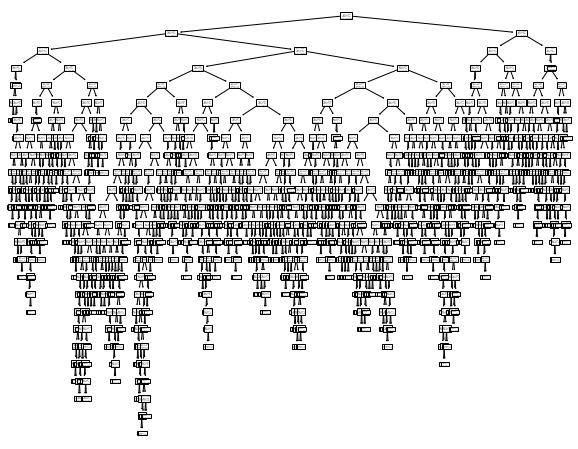

In [20]:
plt.figure(figsize=(10, 8))
plot_tree(tree_clf)
plt.show()

In [25]:
feature_names = ['alcohol', 'sugar', 'pH']
target_names = ['red', 'white']

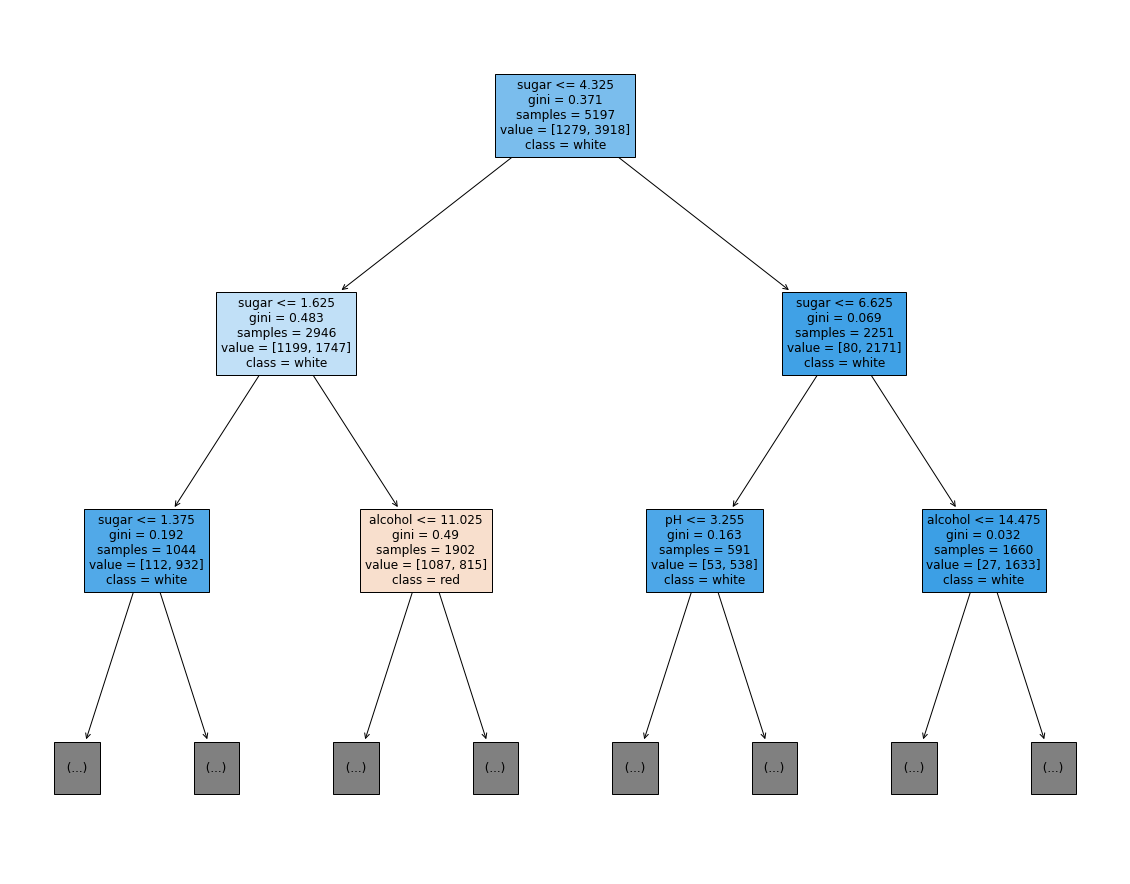

In [27]:
# tree가 너무 복잡하므로, depth=1까지만 시각화
plt.figure(figsize=(20, 16))
plot_tree(tree_clf, max_depth=2,
          feature_names=feature_names,
          class_names=target_names,
          filled=True)
plt.show()

In [23]:
# 이진 분류(binary class)에서 Gini 불순도 계산 방법:
# Gini impurity(불순도) = 1 - ((음성 클래스의 비율)**2 + (양성 클래스의 비율)**2)
1 - ((1279/5197)**2 + (3918/5197)**2)

0.37107315616915937

불순도(impurity):

*   두 클래스가 1:1로 섞여 있으면, 불순도는 최댓값.
>   1 - ((1/2)^2 + (1/2)^2) = 0.5

*   클래스가 완벽하게 분리되어 있으면(1:0, 0:1), 불순도는 최솟값.
>   1 - (1^2 + 0) or 1 - (0 + 1^2) = 0


Entropy(엔트로피) = - ((음성 클래스 비율) x log_2(음성 클래스 비율) + (양성 클래스 비율) x log_2(양성 클래스 비율))


# 규제 파라미터(regularization parameter)

*   `max_depth`: decision tree의 최대 깊이

>   max_depth가 작아질 수록, 규제가 강해져서 훈련 셋에서의 점수가 낮아짐. 하지만, 훈련 셋에서의 점수가 일반화 점수(테스트 셋에서의 점수)와 비슷할 거라 기대할 수 있음. 즉, 과적합(overfitting)이 작아짐.

>   max_depth가 커질 수록, 규제가 약해져서 훈련 셋에서의 점수가 높아짐. 이 점수가 일반화 점수와 비슷할 거라고 기대할 수 없음. 즉, 과적합(overfitting)이 커짐.

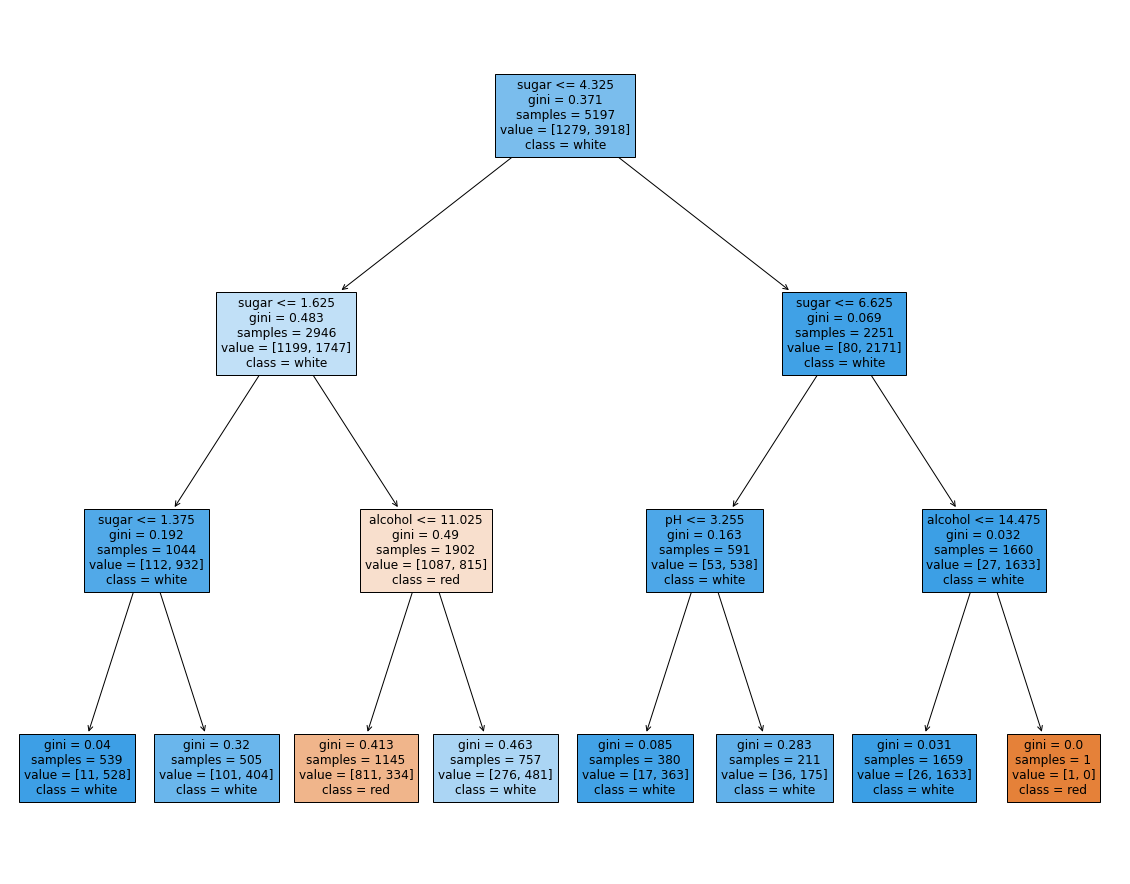

In [31]:
depths = (3, 4, 5, 10, 12, 14, 20)  # 트리의 최대 깊이
train_scores = []  # 각 트리에서 훈련 셋 점수를 저장
test_scores = []  # 각 트리에서 테스트 셋 점수를 저장
for d in depths:  # max_depth 값을 변화시키면서 반복
    tree_clf = DecisionTreeClassifier(max_depth=d, random_state=42)  # 결정 트리 모델 생성
    tree_clf.fit(X_train, y_train)  # 모델 훈련
    tr_sc = tree_clf.score(X_train, y_train)  # 훈련 셋에서의 정확도
    train_scores.append(tr_sc)
    te_sc = tree_clf.score(X_test, y_test)  # 테스트 셋에서의 정확도
    test_scores.append(te_sc)

    # max_depth=3인 경우에만 트리 시각화
    if d == 3:
        plt.figure(figsize=(20, 16))
        plot_tree(tree_clf, feature_names=feature_names, class_names=target_names, filled=True)
        plt.show()

In [32]:
train_scores

[0.8458726188185491,
 0.8595343467385029,
 0.8718491437367712,
 0.9255339619010968,
 0.9538195112564941,
 0.9757552434096595,
 0.9957667885318453]

In [33]:
test_scores

[0.8407692307692308,
 0.8523076923076923,
 0.8576923076923076,
 0.8615384615384616,
 0.8646153846153846,
 0.8661538461538462,
 0.8684615384615385]

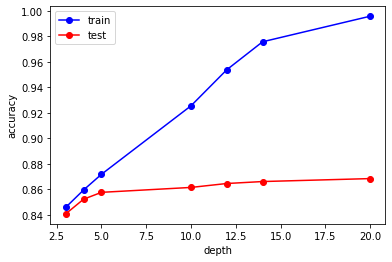

In [35]:
plt.plot(depths, train_scores, 'bo-', label='train')
plt.plot(depths, test_scores, 'ro-', label='test')
plt.legend()
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.show()

결정 트리의 여러가지 규제 파라미터:

*   `min_samples_split`: 분할되기 위해서 노드가 가져야 하는 샘플의 최소 수(또는 비율)
*   `min_samples_leaf`: leaf node가 가지고 있어야 할 샘플의 최소 수(또는 비율)
*   `max_leaf_node`: leaf node의 최대 수
*   `max_features`: 각 노드에서 분할(split)에 사용할 특성의 최대 수

>   `min_`으로 시작하는 파라미터들은 값을 증가시키면, 가지가 줄어듦. 규제가 커짐. overfitting이 작아짐.

>   `max_`로 시작하는 파라미터들은 값을 감소시키면, 가지가 줄어듦. 규제가 커짐. overfitting 작아짐.

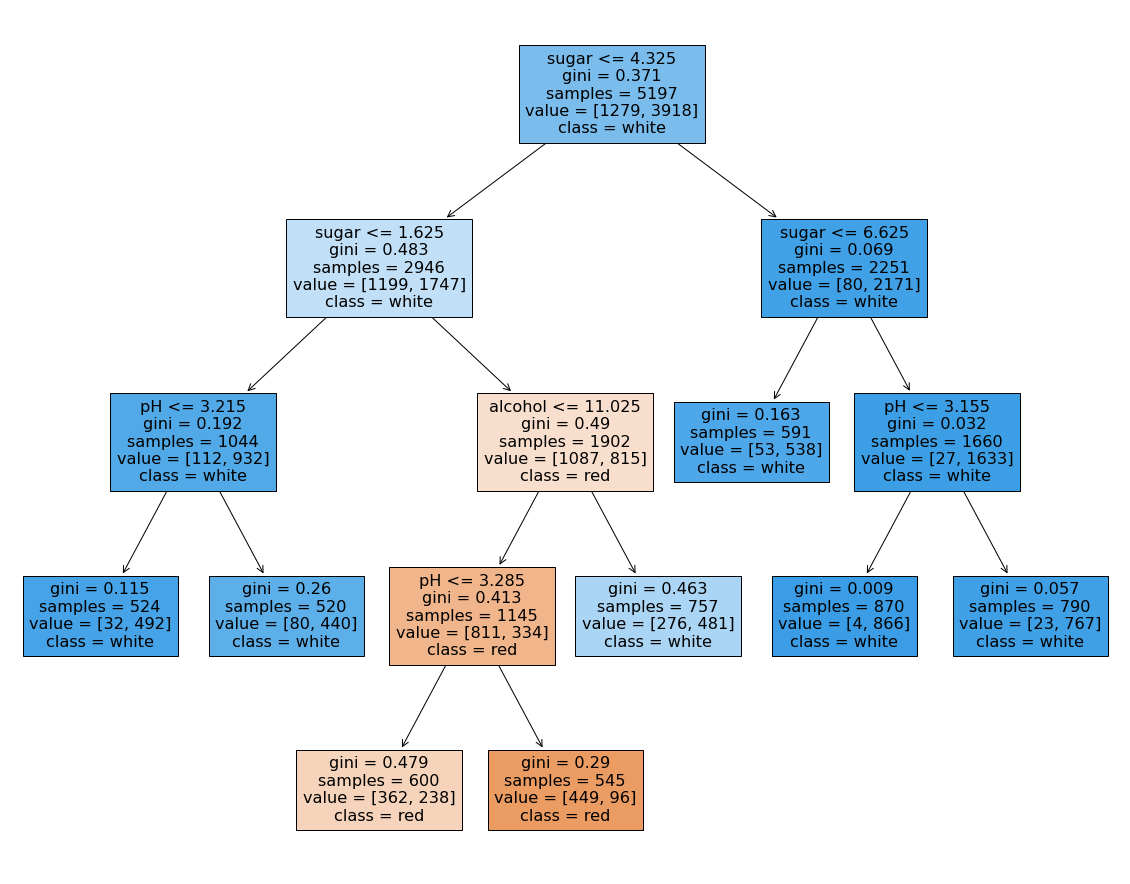

In [39]:
min_samples_leaf = (0.2, 0.1, 0.05, 0.01)
train_scores = []
test_scores = []
for x in min_samples_leaf:
    tree_clf = DecisionTreeClassifier(min_samples_leaf=x, random_state=42)  # 모델 생성
    tree_clf.fit(X_train, y_train)  # 모델 훈련
    # 점수 계산, 리스트에 추가
    train_scores.append(tree_clf.score(X_train, y_train))
    test_scores.append(tree_clf.score(X_test, y_test))

    if x == 0.1:
        plt.figure(figsize=(20, 16))
        plot_tree(tree_clf, feature_names=feature_names, class_names=target_names, filled=True)
        plt.show()

In [40]:
train_scores

[0.8062343659803733,
 0.8456802001154512,
 0.8568404848951318,
 0.8768520300173177]

In [41]:
test_scores

[0.8107692307692308,
 0.8407692307692308,
 0.8476923076923077,
 0.8553846153846154]

In [ ]:
for d in depths:
    for x in min_samples_leaf:
        # pass

# 훈련(Train)/검증(Validation)/테스트(Test) 분리

머신 러닝 과정은 훈련 셋으로 모델을 학습(fit)시키고, 테스트 셋으로 평가(일반화 성능 예측).

하이퍼 파라미터(k, alpha, max_depth, ...)를 변화시키면서 그 성능을 테스트 셋으로 평가하게 되면, 테스트 셋에 맞춰지는(fit) 하이퍼 파라미터를 찾게 됨. 즉, 테스트 셋에 맞춰지는 모델이 만들어지게 됨.

이런 경우 테스트 셋의 평가 점수가 일반화 성능이라고 기대하기는 어렵다.

하이퍼 파라미터를 튜닝할 때는, 훈련 셋을 다시 훈련 셋과 검증 셋으로 나눠서 모델을 (작은) 훈련 셋으로 훈련시키고, 검증 셋의 점수를 사용해서 최적의 하이퍼 파라미터를 찾음.

In [42]:
X.shape

(6497, 3)

In [43]:
# (큰) 훈련 셋/테스트 셋 분리
X_train_full, X_test, y_train_full, y_test = \
        train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [44]:
X_train_full.shape

(5197, 3)

In [45]:
# (작은) 훈련 셋/검증 셋 분리
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full,
                                                  test_size=0.2,
                                                  stratify=y_train_full,
                                                  random_state=42)

In [46]:
X_train.shape

(4157, 3)

In [47]:
# hyperparmeter max_depth 튜닝
train_scores = []
val_scores = []
for depth in range(1, 21):
    tree_clf = DecisionTreeClassifier(max_depth=depth)  # 모델 생성
    tree_clf.fit(X_train, y_train)  # 모델 훈련
    train_scores.append(tree_clf.score(X_train, y_train))  # 훈련 셋 평가
    val_scores.append(tree_clf.score(X_val, y_val))  # 검증 셋(validation set) 평가

In [49]:
np.around(train_scores, decimals=4)

array([0.7539, 0.827 , 0.8273, 0.8636, 0.8691, 0.8776, 0.8889, 0.899 ,
       0.9129, 0.9298, 0.9478, 0.9586, 0.9699, 0.9798, 0.986 , 0.9913,
       0.9952, 0.9971, 0.9976, 0.9981])

In [50]:
np.around(val_scores, decimals=4)

array([0.7538, 0.8298, 0.8298, 0.8644, 0.875 , 0.8683, 0.8625, 0.8663,
       0.8606, 0.8596, 0.8567, 0.8606, 0.8721, 0.8683, 0.8731, 0.8769,
       0.8721, 0.8721, 0.8692, 0.8663])

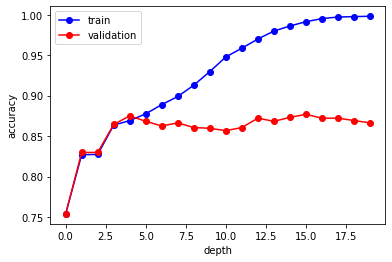

In [52]:
plt.plot(train_scores, 'bo-', label='train')
plt.plot(val_scores, 'ro-', label='validation')

plt.legend()
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.show()

In [54]:
# validation score 최댓값, 인덱스
np.max(val_scores), np.argmax(val_scores)

(0.8769230769230769, 15)

In [55]:
# 만약 val-score가 최댓값인 max_depth를 선택한다면,
tree_clf = DecisionTreeClassifier(max_depth=16, random_state=42)
tree_clf.fit(X_train, y_train)
tree_clf.score(X_test, y_test)

0.8653846153846154

일반적으로 테스트 셋의 평가 점수는 검증 셋의 평가 점수보다 약간 낮습니다.

# 교차 검증(Cross Validation)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [59]:
X_train.shape, X_test.shape

((5197, 3), (1300, 3))

In [60]:
# 교차 검증에서 사용할 모델 생성
tree_clf = DecisionTreeClassifier(random_state=42)

In [62]:
# 교차 검증 수행
cv = cross_validate(estimator=tree_clf, X=X_train, y=y_train,
                    n_jobs=-1,
                    return_train_score=True)
# n_jobs 파라미터: 교차 검증할 때 사용할 CPU 코어(쓰레드) 개수
# n_jobs=None: 기본값. CPU 코어를 1개 사용.
# n_job=-1: 사용가능한 모든 CPU 코어를 이용.
cv

{'fit_time': array([0.01135015, 0.01116467, 0.01322818, 0.01115966, 0.00877309]),
 'score_time': array([0.00110841, 0.00229359, 0.00099421, 0.00097466, 0.00079393]),
 'test_score': array([0.86730769, 0.86923077, 0.84696824, 0.85370549, 0.84985563]),
 'train_score': array([0.99807554, 0.99807554, 0.9983165 , 0.998076  , 0.9983165 ])}

In [63]:
cv['test_score']  # 교차 검증에서 검증 셋들의 점수

array([0.86730769, 0.86923077, 0.84696824, 0.85370549, 0.84985563])

In [64]:
np.mean(cv['test_score'])

0.8574135633375286

In [65]:
# 교차 검증에서의 검증 셋 점수만 필요할 때
cv_score = cross_val_score(tree_clf, X_train, y_train, n_jobs=-1)
cv_score

array([0.86730769, 0.86923077, 0.84696824, 0.85370549, 0.84985563])

In [68]:
# 일반화 성능 계산
tree_clf.fit(X_train, y_train)  # 모델 훈련
tree_clf.score(X_test, y_test)

0.8653846153846154

# GridSearchCV

In [ ]:
clf = DecisionTreeClassifier(random_state=42)  # 교차 검증에서 사용할 모델